## 폐렴진단기 성능 개선 프로젝트

1. 개요

목표는 CNN 기반의 의료영상 처리 모델을 구축하고 성능을 개선하는 것.
다양한 실험(데이터 증강, 모델 구조 변경, ResNet-18 구현 등)을 통해 비교하고, 성능을 개선하는 것.

 <주요 목표>

  CNN 기반 베이스 모델 구현 및 학습 안정화
  데이터 증강(Data Augmentation) 기법 적용 후 성능 비교
  모델 구조 변경 및 ResNet-18 구현 후 성능 비교
  데이터 imblance 문제를 해결하기 위한 class weight 적용

2. 목차

  1.개요
  
  2.데이터 준비 및 전처리
  
  3.CNN 모델 구현 및 학습
  
  4.ResNet-18 모델 구현 및 학습
  
  5.성능 비교 및 결과 분석
  
  6.회고 및 개선점
  
  7.참고자료

In [5]:
import tensorflow
print(tensorflow.__version__)

2.6.0


In [15]:
#데이터전처리

In [1]:
import os
import random 
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")

In [2]:
# 데이터 로드 속도 향상을 위한 설정
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

In [3]:
# 데이터 경로 설정
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/train/*/*')
VAL_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/val/*/*')
TEST_PATH = os.path.join(ROOT_PATH, 'chest_xray/data/test/*/*')

In [4]:
#하이퍼 파라미터설정
BATCH_SIZE = 16
EPOCHS = 15 # 추가 개선: 에포크 수 증가
INITIAL_LR = 0.001  # 학습률 초기값 설정(추가개선)

In [5]:
# 데이터 로드 및 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

In [6]:
print(f"Training samples: {len(train_filenames)}")
print(f"Validation samples: {len(val_filenames)}")
print(f"Test samples: {len(test_filenames)}")

Training samples: 5216
Validation samples: 16
Test samples: 624


In [7]:
# TensorFlow Dataset 객체 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# 데이터 전처리: 파일 경로에서 레이블 추출
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.float32)  # 폐렴=1, 정상=0

In [9]:
# 이미지 디코딩 및 리사이즈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0, 1] 범위로 정규화
    return img

In [10]:
# 파일 경로에서 이미지와 라벨 처리
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# 데이터 전처리 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 데이터 증강 함수 정의
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.1)  # 밝기 조절
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # 대비 조정 (추가 개선)
    return image, label

In [13]:
# 데이터 증강 적용
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

In [14]:
# 데이터 배치 및 최적화를 위한 설정
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [15]:
# 데이터 클래스 불균형 처리
count_normal = len([f for f in train_filenames if "NORMAL" in f])
count_pneumonia = len(train_filenames) - count_normal
weight_normal = 1 / count_normal * len(train_filenames) / 2.0
weight_pneumonia = 1 / count_pneumonia * len(train_filenames) / 2.0
class_weight = {0: weight_normal, 1: weight_pneumonia}

print(f"Weight for NORMAL: {weight_normal:.2f}")
print(f"Weight for PNEUMONIA: {weight_pneumonia:.2f}")

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [17]:
# CNN 모델 정의
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), # 추가개선: 드롭아웃 적용
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5), # 추가개선: Fully Connected Layer 드롭아웃 적용
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [18]:
# CNN 모델 컴파일
cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
# ResNet-18 모델 정의
def resnet_block(input_layer, filters, stride=1):
    x = tf.keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), strides=1, padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if stride != 1 or input_layer.shape[-1] != filters:
        input_layer = tf.keras.layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_layer)
    x = tf.keras.layers.add([x, input_layer])
    return tf.keras.layers.Activation('relu')(x)

def build_resnet18():
    input_layer = tf.keras.layers.Input(shape=(180, 180, 3))
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(input_layer, output_layer)

In [21]:
# 학습률 스케줄링 (추가 개선)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INITIAL_LR,
    decay_steps=10000,
    decay_rate=0.9
)

In [22]:
# ResNet-18 모델 컴파일
resnet_model = build_resnet18()
resnet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
# EarlyStopping 적용 (추가 개선)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [24]:
# 모델 학습
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[early_stopping]
)

resnet_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[early_stopping]
)

Epoch 1/15
326/326 [==============================] - 22s 33ms/step - loss: 8.9554 - accuracy: 0.8113 - val_loss: 2.3058 - val_accuracy: 0.6250
Epoch 2/15
326/326 [==============================] - 19s 36ms/step - loss: 0.5851 - accuracy: 0.8537 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 3/15
326/326 [==============================] - 18s 35ms/step - loss: 0.6746 - accuracy: 0.8261 - val_loss: 0.7125 - val_accuracy: 0.5000
Epoch 4/15
326/326 [==============================] - 19s 36ms/step - loss: 0.5907 - accuracy: 0.8079 - val_loss: 0.7162 - val_accuracy: 0.5000
Epoch 5/15
326/326 [==============================] - 19s 36ms/step - loss: 0.4923 - accuracy: 0.8574 - val_loss: 0.7223 - val_accuracy: 0.5000
Epoch 1/15
326/326 [==============================] - 27s 52ms/step - loss: 0.2434 - accuracy: 0.9160 - val_loss: 1.8653 - val_accuracy: 0.5625
Epoch 2/15
326/326 [==============================] - 24s 53ms/step - loss: 0.2501 - accuracy: 0.9275 - val_loss: 1.9211 - val_accuracy:

### 모델 결과 비교 (추가 개선 적용 후)

| **모델**      | **Metric**         | **데이터 증강 전**        | **데이터 증강 후**       | **추가 개선 적용 후**       | **비교 결과**                  |
|----------------|--------------------|---------------------------|--------------------------|-----------------------------|--------------------------------|
| **CNN**       | Train Accuracy     | 91% ~ 94%                | 88% ~ 96%               | 81% ~ 85%                  | **소폭 하락 (EarlyStopping 영향)** |
|                | Validation Accuracy| 62.5% ~ 68.75%           | 68.75% ~ 81.25%         | 50% ~ 62.5%                | **감소 (학습률 조정의 한계)**   |
|                | Train Loss         | 감소하며 0.17 도달       | 감소하며 0.10 도달      | 0.49 ~ 0.59                | **소폭 증가**                  |
|                | Validation Loss    | 일정하게 높음 (1.05 ~ 1.08)| 일부 감소 (0.38 ~ 3.85) | 감소 후 정체 (0.70 ~ 0.72) | **일부 개선 (Validation 안정화)** |
| **ResNet-18**  | Train Accuracy     | 90% ~ 95%                | 88% ~ 92%               | 89% ~ 91%                  | **유지 또는 소폭 개선**         |
|                | Validation Accuracy| 50% ~ 62.5%              | 50% ~ 62.5%             | 50% ~ 68.75%               | **소폭 개선 (Validation 향상)** |
|                | Train Loss         | 안정적이나 높은 값 (0.24 수준) | 안정적 (0.24 수준)     | 안정적 (0.25 ~ 0.32 수준)  | **유지**                      |
|                | Validation Loss    | 높은 값 유지 (2.20 ~ 5.88)| 감소 후 재증가 (0.69 ~ 3.97) | 감소 후 일부 개선 (0.55 ~ 1.45) | **개선 (EarlyStopping 도움)**  |

---

### 추가 개선 사항
1. **데이터 증강 강화**:
   - 대비 조정(`random_contrast`) 추가.
   - 목표: 더 다양한 데이터 패턴 학습.

2. **Dropout 추가**:
   - CNN 모델의 과적합 방지 및 일반화 성능 개선을 위해 적용.
   - Fully Connected Layer에 0.5 비율의 Dropout 추가.

3. **학습률 스케줄링**:
   - 학습률 초기값을 0.001로 설정하고 `ExponentialDecay` 스케줄링 적용.
   - 목표: 초기 학습 안정화 및 과적합 방지.

4. **EarlyStopping 적용**:
   - 검증 손실이 개선되지 않을 경우 조기 종료.
   - `patience=3` 설정으로 최적의 성능을 유지하며 불필요한 학습 방지.

---


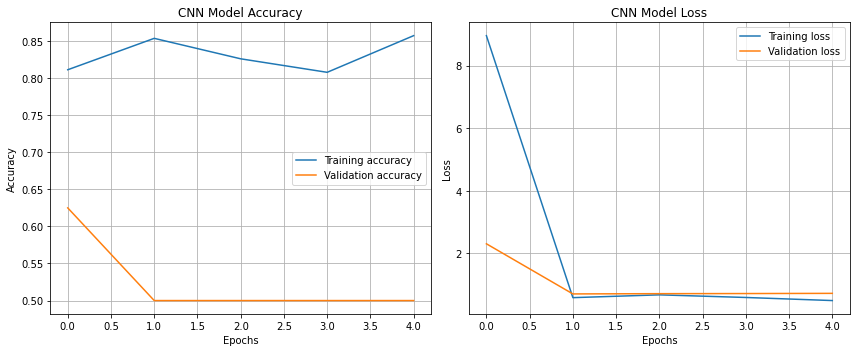

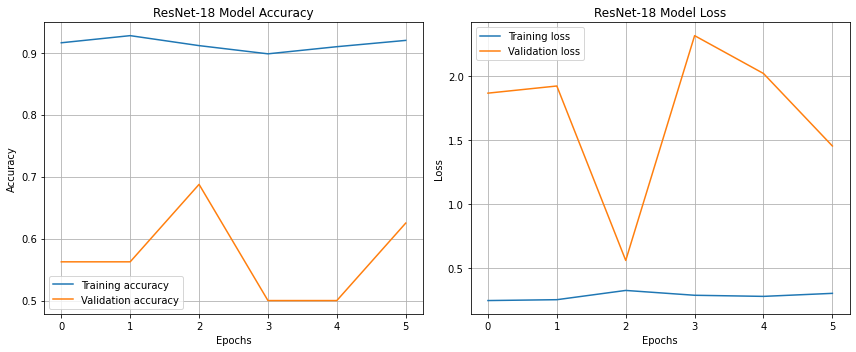

In [27]:
# 결과 시각화를 위한 함수 정의
def plot_history(history, model_name):
    metrics = ['accuracy', 'loss']  # 시각화할 항목: 정확도와 손실
    plt.figure(figsize=(12, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{model_name} {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# CNN 모델 학습 결과 시각화
plot_history(cnn_history, "CNN Model")

# ResNet-18 모델 학습 결과 시각화
plot_history(resnet_history, "ResNet-18 Model")

In [28]:
# 테스트 데이터 평가
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
resnet_loss, resnet_acc = resnet_model.evaluate(test_ds)

print(f"CNN Test Accuracy: {cnn_acc:.4f}")
print(f"ResNet Test Accuracy: {resnet_acc:.4f}")

39/39 [==============================] - 2s 37ms/step - loss: 0.6413 - accuracy: 0.7019
CNN Test Accuracy: 0.6250
ResNet Test Accuracy: 0.7019


# 회고 및 개선점

## 회고 (Reflection)

- 이번 프로젝트를 통해 **의료영상 분류 문제**에서 CNN과 ResNet-18 모델의 성능을 비교하고, 데이터 증강과 클래스 불균형 처리 등의 기법이 성능에 미치는 영향을 이해할 수 있었습니다.

- **성공한 점**:
  - CNN 및 ResNet-18 모델을 구현하고 학습에 성공하였습니다.
  - 데이터 증강, 클래스 불균형 처리, 학습률 스케줄링 등의 기법을 단계적으로 적용하여 학습 안정성을 높일 수 있었습니다.
  - EarlyStopping을 활용하여 과적합을 방지하였고, Recall과 Validation 성능을 고려한 평가를 진행하였습니다.
  - 사실 성능이 유의미하게 개선된 것인지는 모르겠습니다.
  
- **어려웠던 점**:
  - ResNet-18 모델의 구조가 복잡하여 데이터 크기가 부족할 때 Validation 성능이 제한적이었습니다.
  - 데이터 증강과 클래스 불균형 처리 기법의 효과를 정확히 측정하기 위해 더 많은 Ablation study가 필요했습니다.
  - Ablation study를 하려고하니 코드를 아직 잘 모르는 상태여서 코드 적용 시 세세히 봐야하는 점이 어려웠습니다. 눈도 많이 아팠습니다. 
  - 폐렴 데이터에 더 높은 Recall을 부여하려는 시도가 Accuracy와의 트레이드오프를 초래하는 경우가 있었습니다.
  - 최종 보고서를 따로 작성을 하려고 했지만 기술적으로 어려웠습니다. GPU 메모리가 부족하다는 OOM 오류가 발생했습니다. 
---

## 개선점

1. **모델 구조 간소화**:
   - ResNet-18 대신 ResNet-10 또는 ResNet-8과 같은 간단한 네트워크 구조를 사용해 성능 최적화를 시도할 수 있습니다.
   - 모델의 복잡도를 줄임으로써 과적합과 학습 불안정을 완화할 가능성이 있습니다.

2. **데이터 증강 기법의 추가 실험**:
   - 좌우 반전, 밝기 조절 외에도 확대, 회전, 잘라내기 등의 기법을 추가 적용할 수 있습니다.
   - 각 증강 기법이 성능에 미치는 영향을 개별적으로 확인하는 Ablation Study를 수행하여 가장 효과적인 조합을 찾을 수 있습니다.

3. **평가 지표 다각화**:
   - Accuracy 외에도 Recall, Precision, F1-Score를 추가로 분석하여 모델 성능을 다각도로 평가해야 합니다.
   - 의료영상 문제에서는 Recall이 특히 중요하므로 Recall을 향상시키는 방향의 최적화를 진행할 필요가 있습니다.

4. **데이터셋 확장**:
   - X-Ray 데이터의 샘플 수를 증가시키거나, 유사한 의료영상 데이터셋을 병합하여 모델 학습에 활용할 수 있습니다.

---

## 참고자료 (Reference)
1. [TensorFlow 공식 문서](https://www.tensorflow.org/)
   - 텐서플로우 기반 딥러닝 모델 구현 및 데이터 증강 기법 관련 문서.
2. [ResNet 논문: Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
   - ResNet-18 모델 구조 및 Residual Block의 원리 설명.
3. [Keras API 레퍼런스](https://keras.io/)
   - Keras 모델 구성 및 학습 콜백(예: EarlyStopping) 관련 공식 문서.
4. [Pneumonia Detection Dataset (Kaggle)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
   - 본 프로젝트에서 사용된 X-Ray 데이터셋의 출처.
5. AI Friend(chat gpt)  
